# THB/USD Exchange Rate Forecasting using Autoregressive Distributed Lag (ARDL) Models

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

sns.set_theme(style="white", context="talk")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["figure.dpi"] = 300


## 1. Pre-processing

In [2]:
df = pd.read_csv('data/clean_data.csv', parse_dates=['date'], index_col='date')
df.head()


,BAHT,RMS_TH,RINT_TH,RINT_IPI
date,,,,
2010-01-01,33.0353,-0.0002,0.19,-0.158353
2010-02-01,33.1491,0.0004,-0.05,-0.186851
2010-03-01,32.5077,-0.0013,0.32,-0.187540
2010-04-01,32.2877,0.0010,-0.41,-0.270556
2010-05-01,32.3946,0.0038,-0.07,-0.150433


<AxesSubplot:xlabel='date', ylabel='RINT_IPI'>

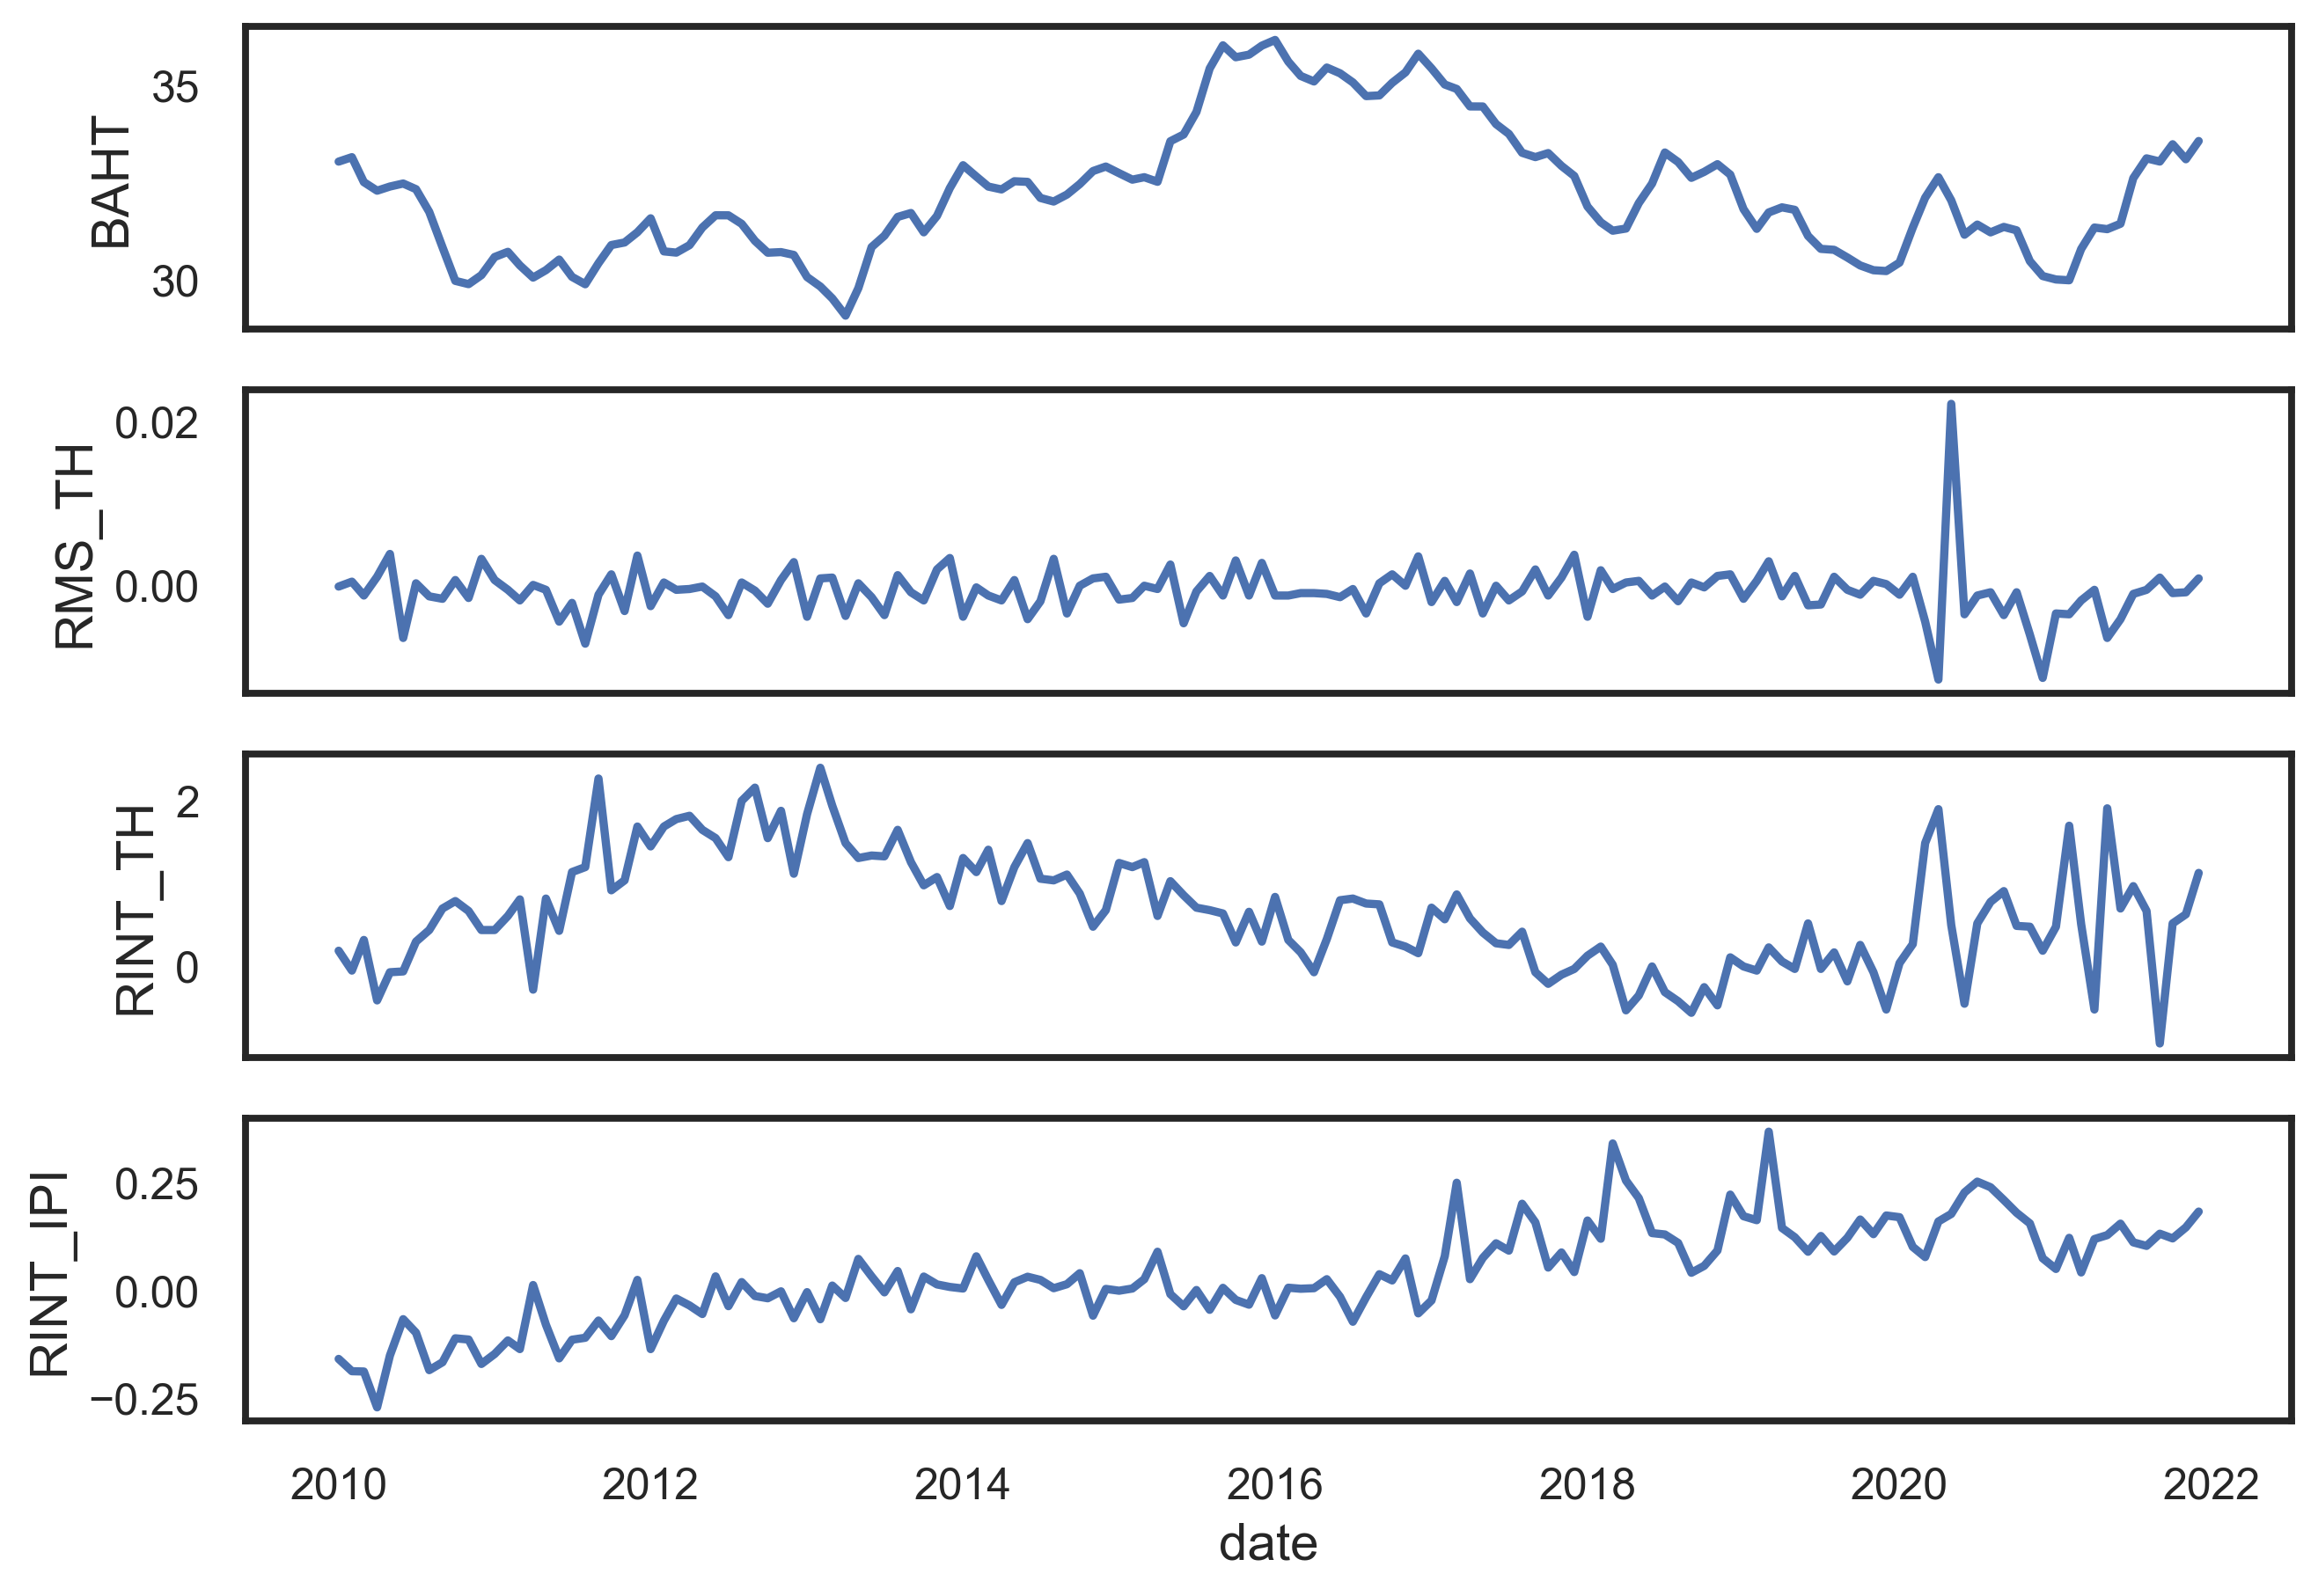

In [3]:
fig, ax = plt.subplots(nrows=4, sharex=True)
sns.lineplot(x='date', y='BAHT', data=df, ax=ax[0])
sns.lineplot(x='date', y='RMS_TH', data=df, ax=ax[1])
sns.lineplot(x='date', y='RINT_TH', data=df, ax=ax[2])
sns.lineplot(x='date', y='RINT_IPI', data=df, ax=ax[3])


## 2. Unit Root Test

$$
Y_t = \alpha Y_{t-1} + \beta X_e + \epsilon
$$

### Augmented Dickey Fuller (ADF) Test

$$
y_t = c + \beta t + \alpha y_{t-1} + \Phi \Delta Y_{t-1} + \epsilon_t
$$

where
- $y_{t-1}$ is lag 1 of time series
- $\Delta Y_{t-1}$ is first difference of the series at time $t-1$

In [4]:
from arch.unitroot import ADF


In [5]:
adf = ADF(df['BAHT'], trend="ctt")
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.177
P-value                         0.741
Lags                                2
-------------------------------------

Trend: Constant, Linear and Quadratic Time Trends
Critical Values: -4.46 (1%), -3.87 (5%), -3.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [6]:
adf = ADF(df['RMS_TH'], trend="n")
print(adf.summary().as_text())


   Augmented Dickey-Fuller Results   
Test Statistic                 -5.352
P-value                         0.000
Lags                                2
-------------------------------------

Trend: No Trend
Critical Values: -2.58 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [7]:
adf = ADF(df['RINT_TH'], trend="n")
print(adf.summary().as_text())


   Augmented Dickey-Fuller Results   
Test Statistic                 -0.805
P-value                         0.368
Lags                                5
-------------------------------------

Trend: No Trend
Critical Values: -2.58 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [8]:
adf = ADF(df['RINT_IPI'], trend="ct")
print(adf.summary().as_text())


   Augmented Dickey-Fuller Results   
Test Statistic                 -5.505
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.02 (1%), -3.44 (5%), -3.15 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### First Difference

จากการทำ ADF Test พบว่า `BAHT` และ `RINT_TH` มี Unit Root จึงต้องนำมาทำ first difference

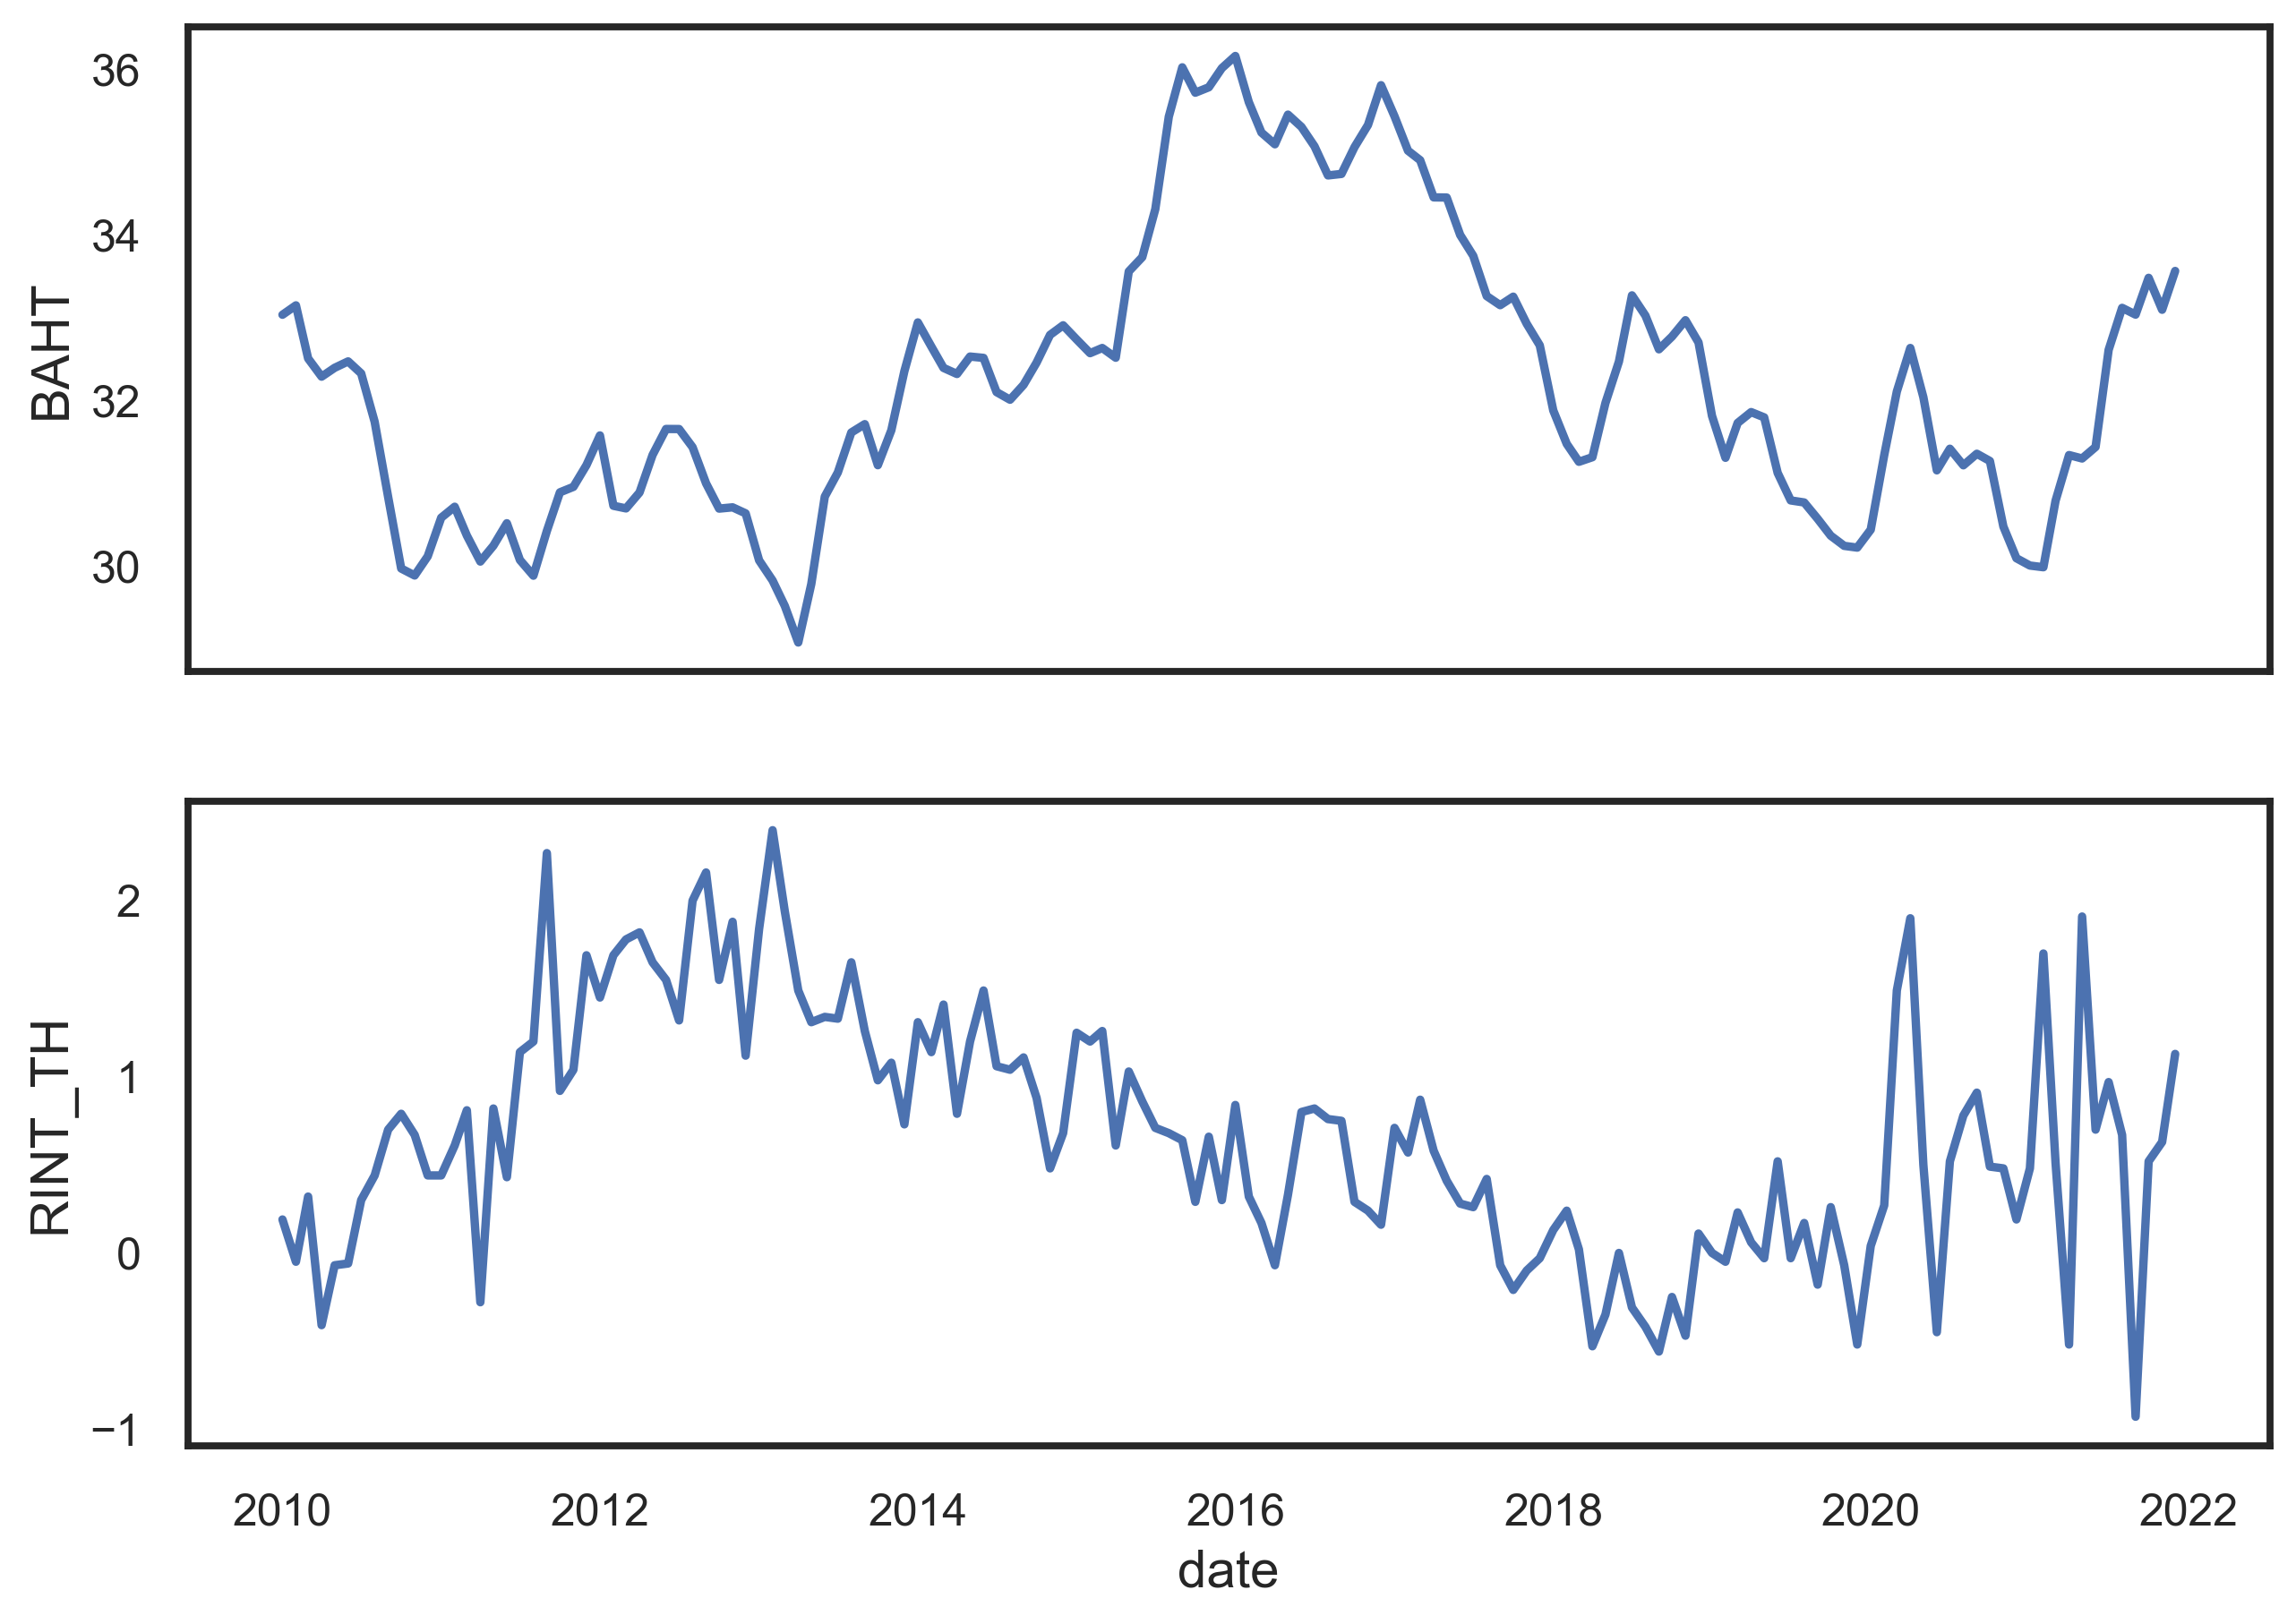

In [9]:
fig, ax = plt.subplots(nrows=2, sharex=True)
sns.lineplot(x='date', y='BAHT', data=df, ax=ax[0])
sns.lineplot(x='date', y='RINT_TH', data=df, ax=ax[1])
plt.show()

In [10]:
df_diff = df.diff().dropna()
df_diff.head()

,BAHT,RMS_TH,RINT_TH,RINT_IPI
date,,,,
2010-02-01,0.1138,0.0006,-0.24,-0.028498
2010-03-01,-0.6414,-0.0017,0.37,-0.000688
2010-04-01,-0.2200,0.0023,-0.73,-0.083017
2010-05-01,0.1069,0.0028,0.34,0.120123
2010-06-01,0.0777,-0.0103,0.01,0.084078


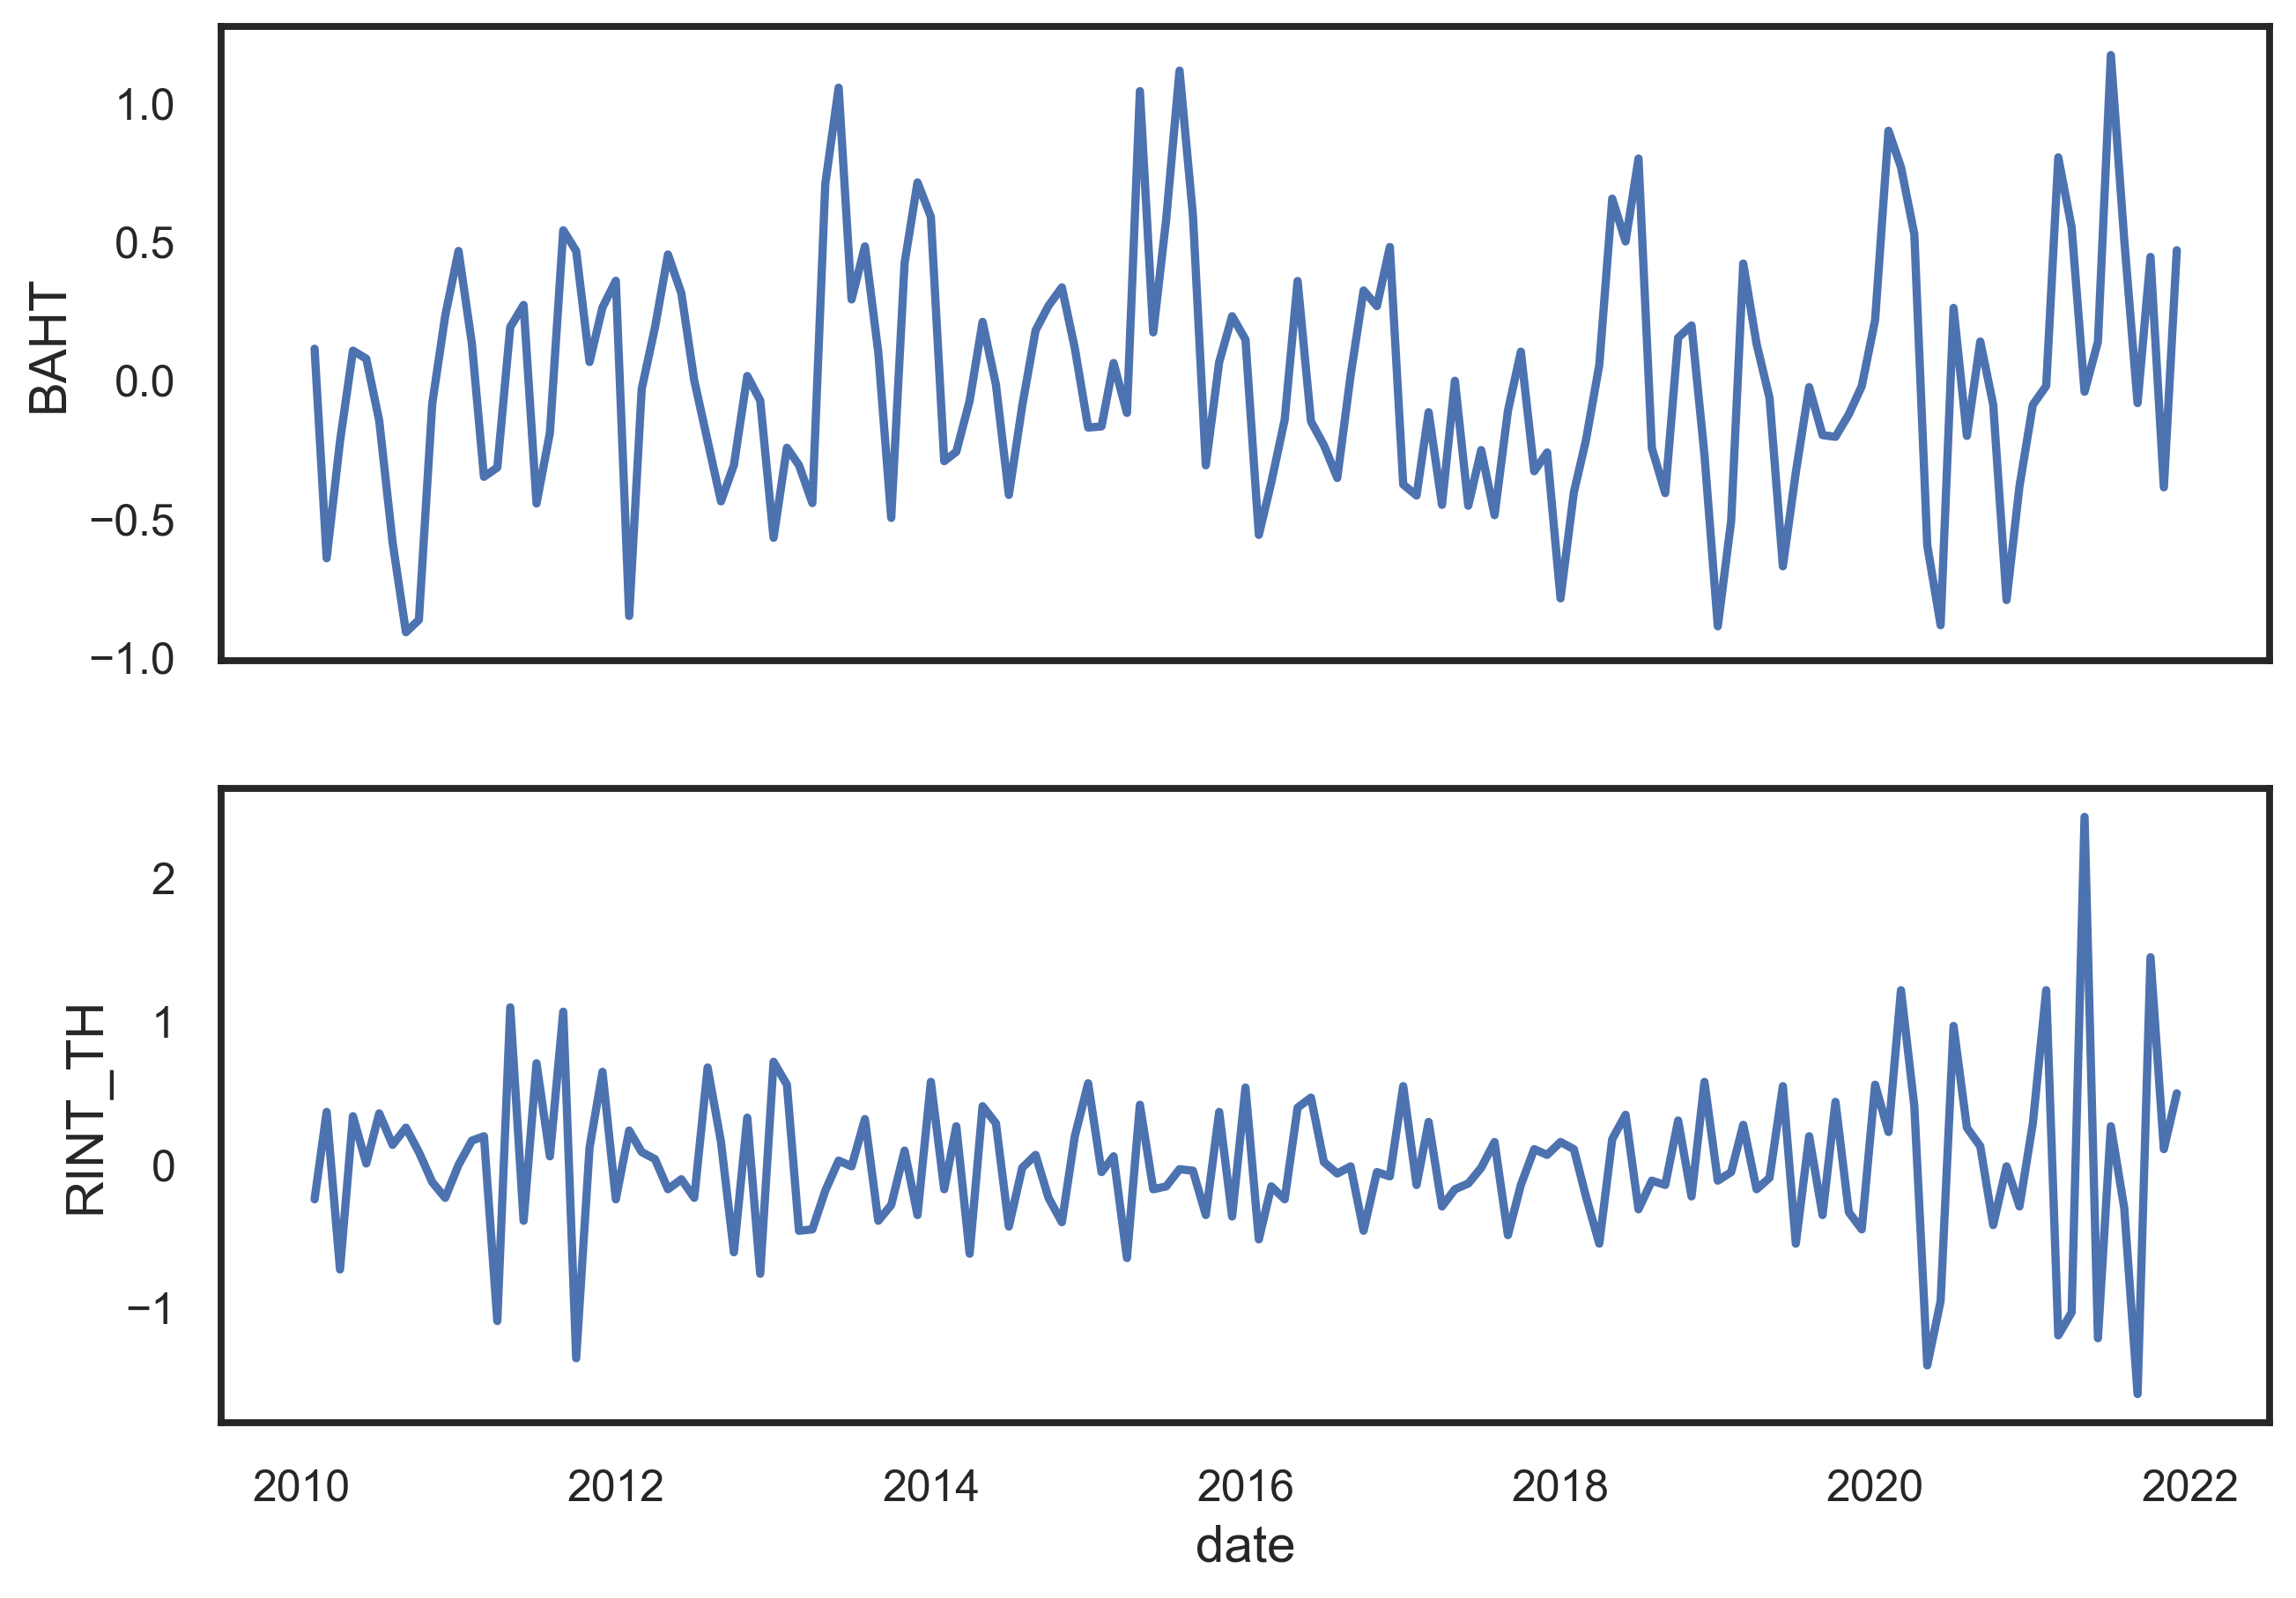

In [11]:
fig, ax = plt.subplots(nrows=2, sharex=True)
sns.lineplot(x='date', y='BAHT', data=df_diff, ax=ax[0])
sns.lineplot(x='date', y='RINT_TH', data=df_diff, ax=ax[1])
plt.show()

In [12]:
adf = ADF(df_diff['BAHT'], trend="ctt")
print(adf.summary().as_text())


   Augmented Dickey-Fuller Results   
Test Statistic                 -7.887
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant, Linear and Quadratic Time Trends
Critical Values: -4.46 (1%), -3.87 (5%), -3.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [13]:
adf = ADF(df_diff['RINT_TH'], trend="n")
print(adf.summary().as_text())


   Augmented Dickey-Fuller Results   
Test Statistic                 -9.100
P-value                         0.000
Lags                                4
-------------------------------------

Trend: No Trend
Critical Values: -2.58 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


ผลการทดสอบความนิ่งของตัวแปร

| ตัวแปร   | สมการที่ใช้ทดสอบ | ความล่าช้าที่เหมาะสม | ADF Statistics | p-value | ผลการทดสอบ    |
| -------- | ---------------- | -------------------- | -------------- | ------- | ------------- |
| BAHT     | `ctt`            | 2                    | -2.177         | 0.741   | ไม่มีความนิ่ง |
| RMS_TH   | `n`              | 2                    | -5.352         | 0.000   | มีความนิ่ง    |
| RINT_TH  | `n`              | 5                    | -0.805         | 0.368   | ไม่มีความนิ่ง |
| RINT_IPI | `ct`             | 1                    | -5.505         | 0.000   | มีความนิ่ง    |

ผลการทดสอบความนิ่งของตัวแปรหลังจากทำ Firse Difference

| ตัวแปร   | สมการที่ใช้ทดสอบ | ความล่าช้าที่เหมาะสม | ADF Statistics | p-value | ผลการทดสอบ |
| -------- | ---------------- | -------------------- | -------------- | ------- | ---------- |
| DBAHT    | `ctt`            | 1                    | -7.887         | 0.000   | มีความนิ่ง |
| DRINT_TH | `ctt`            | 4                    | -9.100         | 0.000   | มีความนิ่ง |

สมการที่ใช้ทดสอบ

- `c` : Constant only

- `ct`: Constant and trend.

- `ctt` : Constant, and linear and quadratic trend.

- `n` : No deterministic terms


## 3. Bounds Testing

In [14]:
from statsmodels.tsa.api import ARDL, UECM
from statsmodels.tsa.ardl import ardl_select_order


In [15]:
ecm = UECM(df.BAHT, 1, df[["RMS_TH", "RINT_TH", "RINT_IPI"]], 6, trend="c")
ecm_fit = ecm.fit()
bounds_test = ecm_fit.bounds_test(case=3)
bounds_test


/Users/chatree/opt/miniconda3/envs/py4ai/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chatree/opt/miniconda3/envs/py4ai/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


BoundsTestResult
Stat: 2.53677
Upper P-value: 0.325
Lower P-value: 0.0881
Null: No Cointegration
Alternative: Possible Cointegration

In [16]:
bounds_test.crit_vals


,lower,upper
percentile,,
90.0,2.456553,3.516144
95.0,2.877209,4.010500
99.0,3.779853,5.050468
99.9,4.985268,6.402243


## 4. ARDL Model

### Direct Parameterization

In [17]:
ardl_model = ARDL(
    df.BAHT, 1, df[["RMS_TH", "RINT_TH", "RINT_IPI"]], {"RMS_TH": 2, "RINT_TH": 4, "RINT_IPI": 1}, trend="c"
).fit()
ardl_model.summary()


/Users/chatree/opt/miniconda3/envs/py4ai/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                   BAHT   No. Observations:                  144
Model:               ARDL(1, 2, 4, 1)   Log Likelihood                 -74.314
Method:               Conditional MLE   S.D. of innovations              0.407
Date:                Sat, 04 Jun 2022   AIC                            174.629
Time:                        16:37:59   BIC                            213.146
Sample:                    05-01-2010   HQIC                           190.280
                         - 12-01-2021                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.6278      0.757      0.829      0.409      -0.870       2.126
BAHT.L1         0.9780      0.023     42.778      0.000       0.933       1.023
RMS_TH.L0       8.7176     12.635      0.690      0.491     -16.277      33.712
RMS_TH.L1     -11.9164     13.385     -0.890      0.375     -38.396      14.563
RMS_TH.L2     -14.6407     12.865     -1.138      0.257     -40.090      10.809
RINT_TH.L0      0.0539      0.085      0.633      0.528      -0.114       0.222
RINT_TH.L1     -0.1684      0.089     -1.884      0.062      -0.345       0.008
RINT_TH.L2      0.0204      0.089      0.229      0.819      -0.155       0.196
RINT_TH.L3      0.0117      0.087      0.134      0.894      -0.161       0.184
RINT_TH.L4      0.1795      0.082      2.177      0.031       0.016       0.343
RINT_IPI.L0    -0.7141      0.578     -1.236      0.219      -1.857       0.429
RINT_IPI.L1     0.9867      0.567      1.740      0.084      -0.135       2.108
===============================================================================
"""

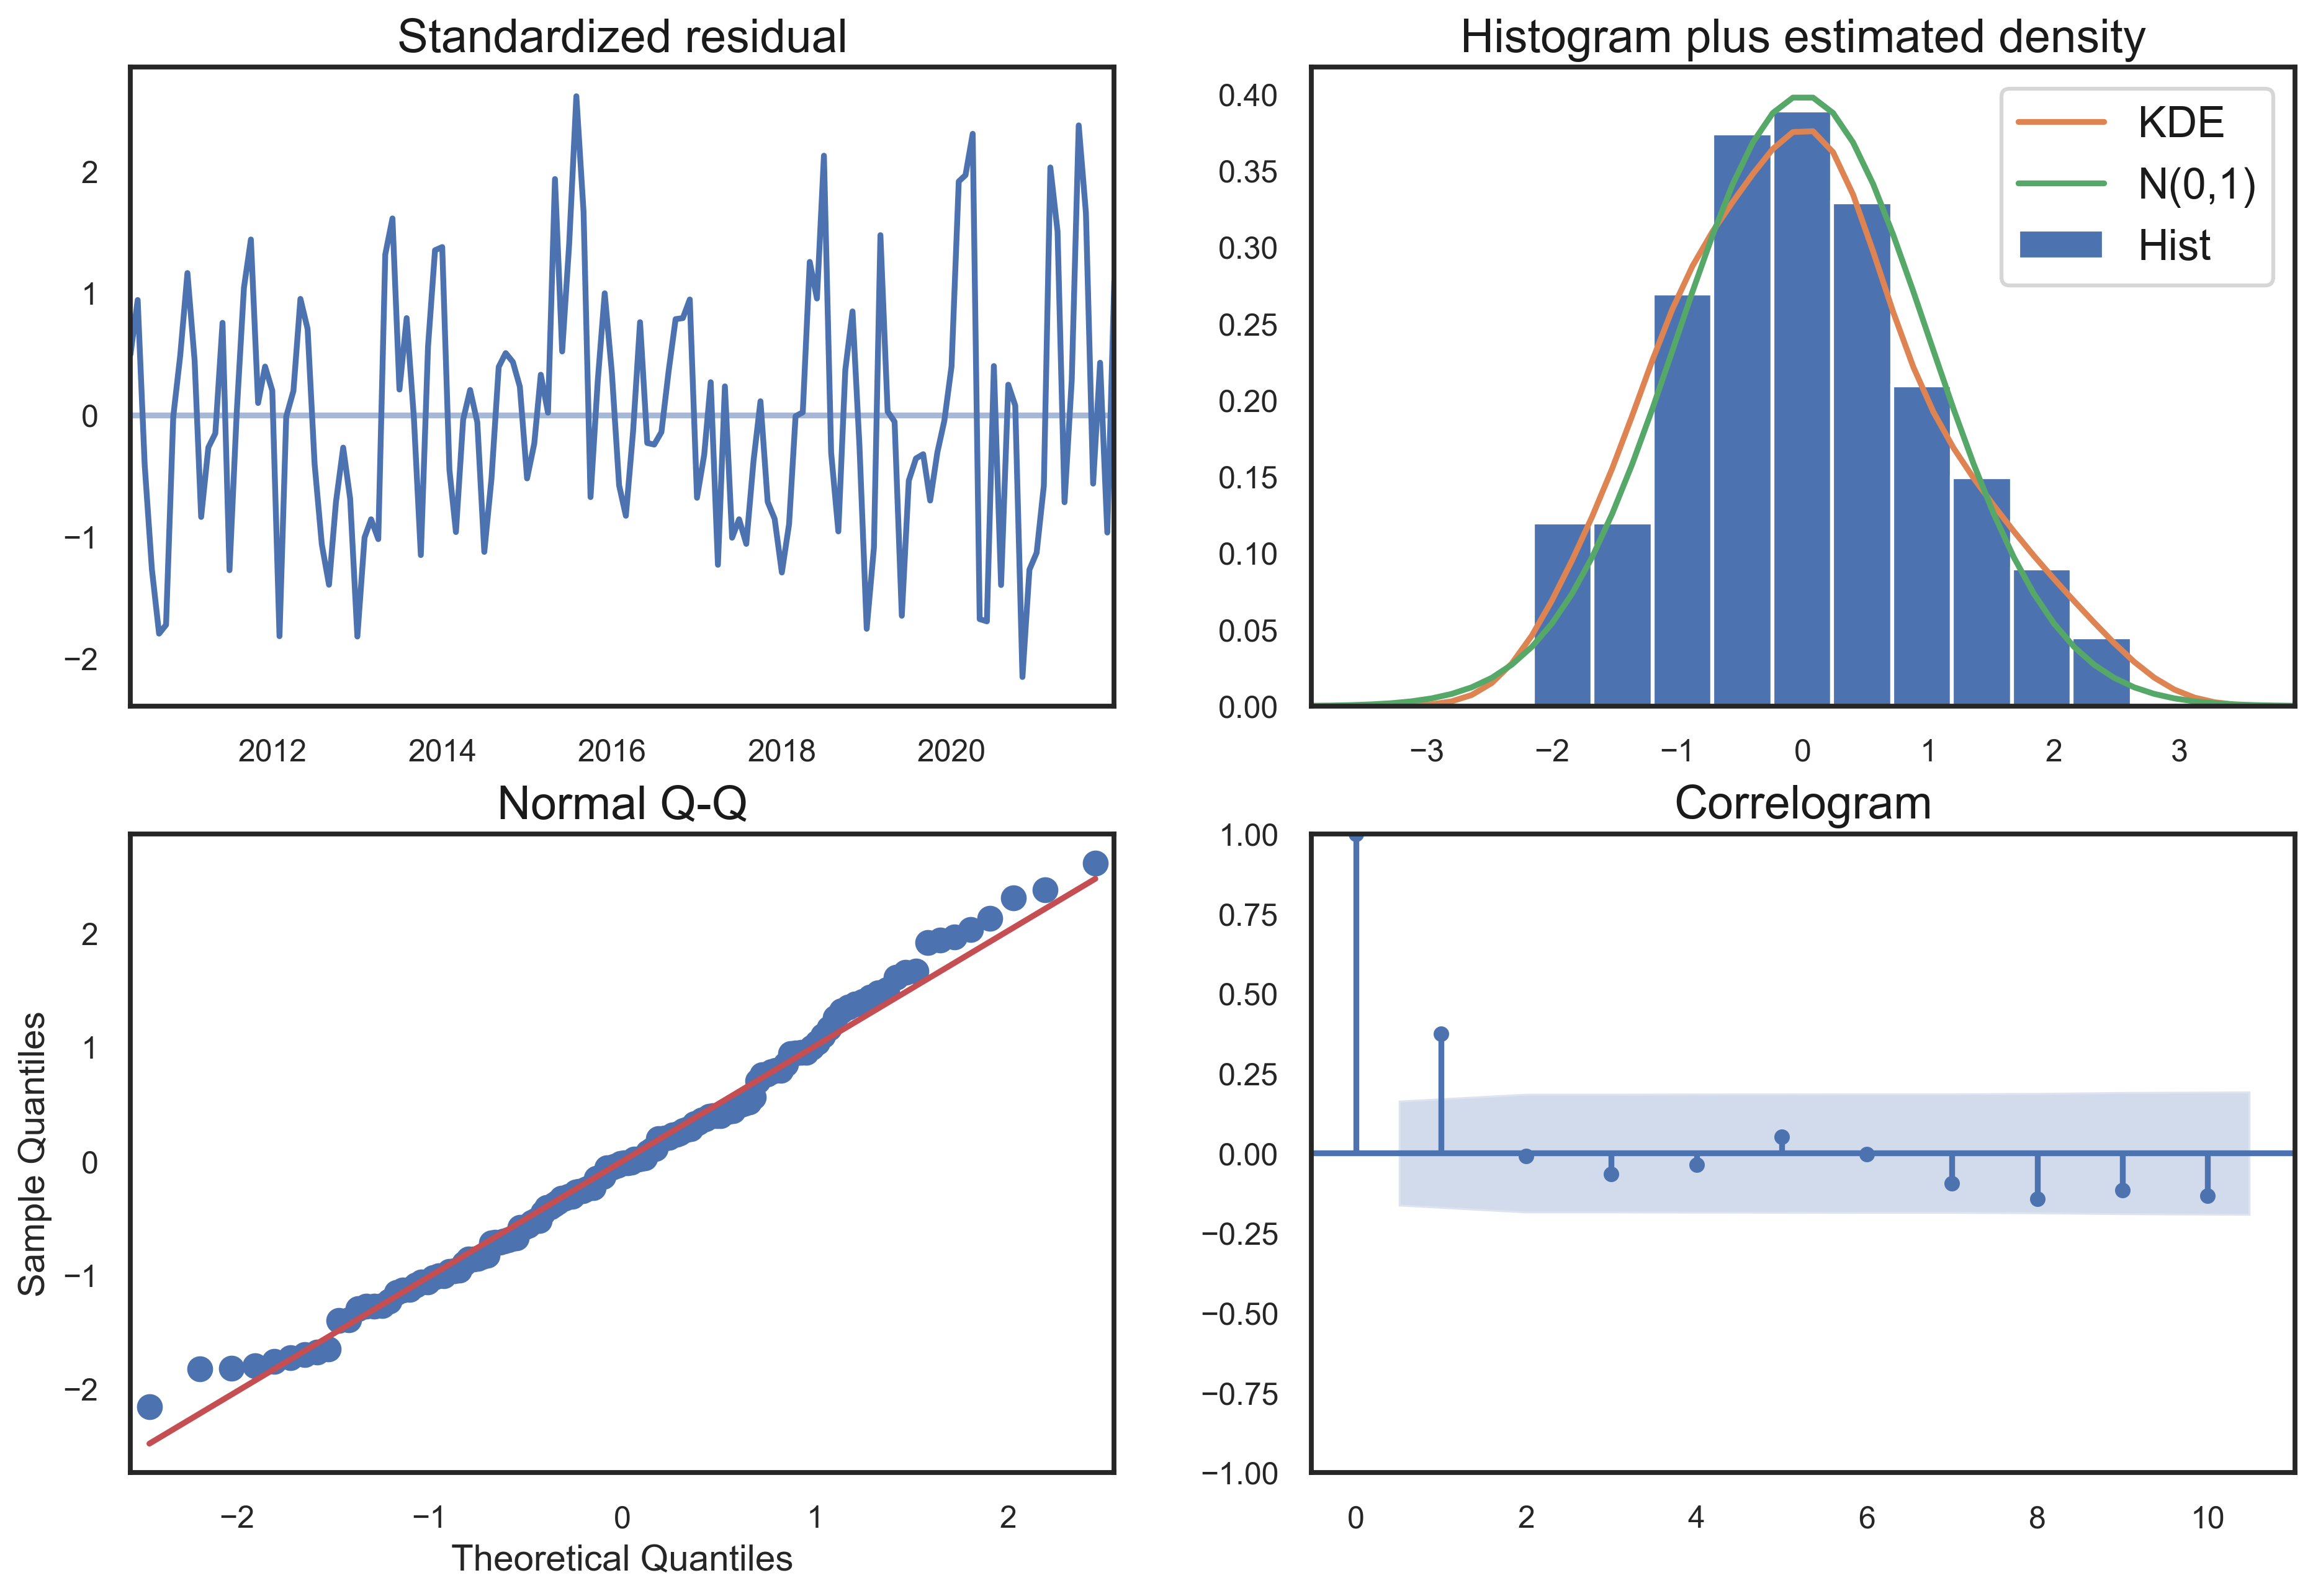

In [30]:
ardl_model.plot_diagnostics(figsize=(15, 10))
plt.show()

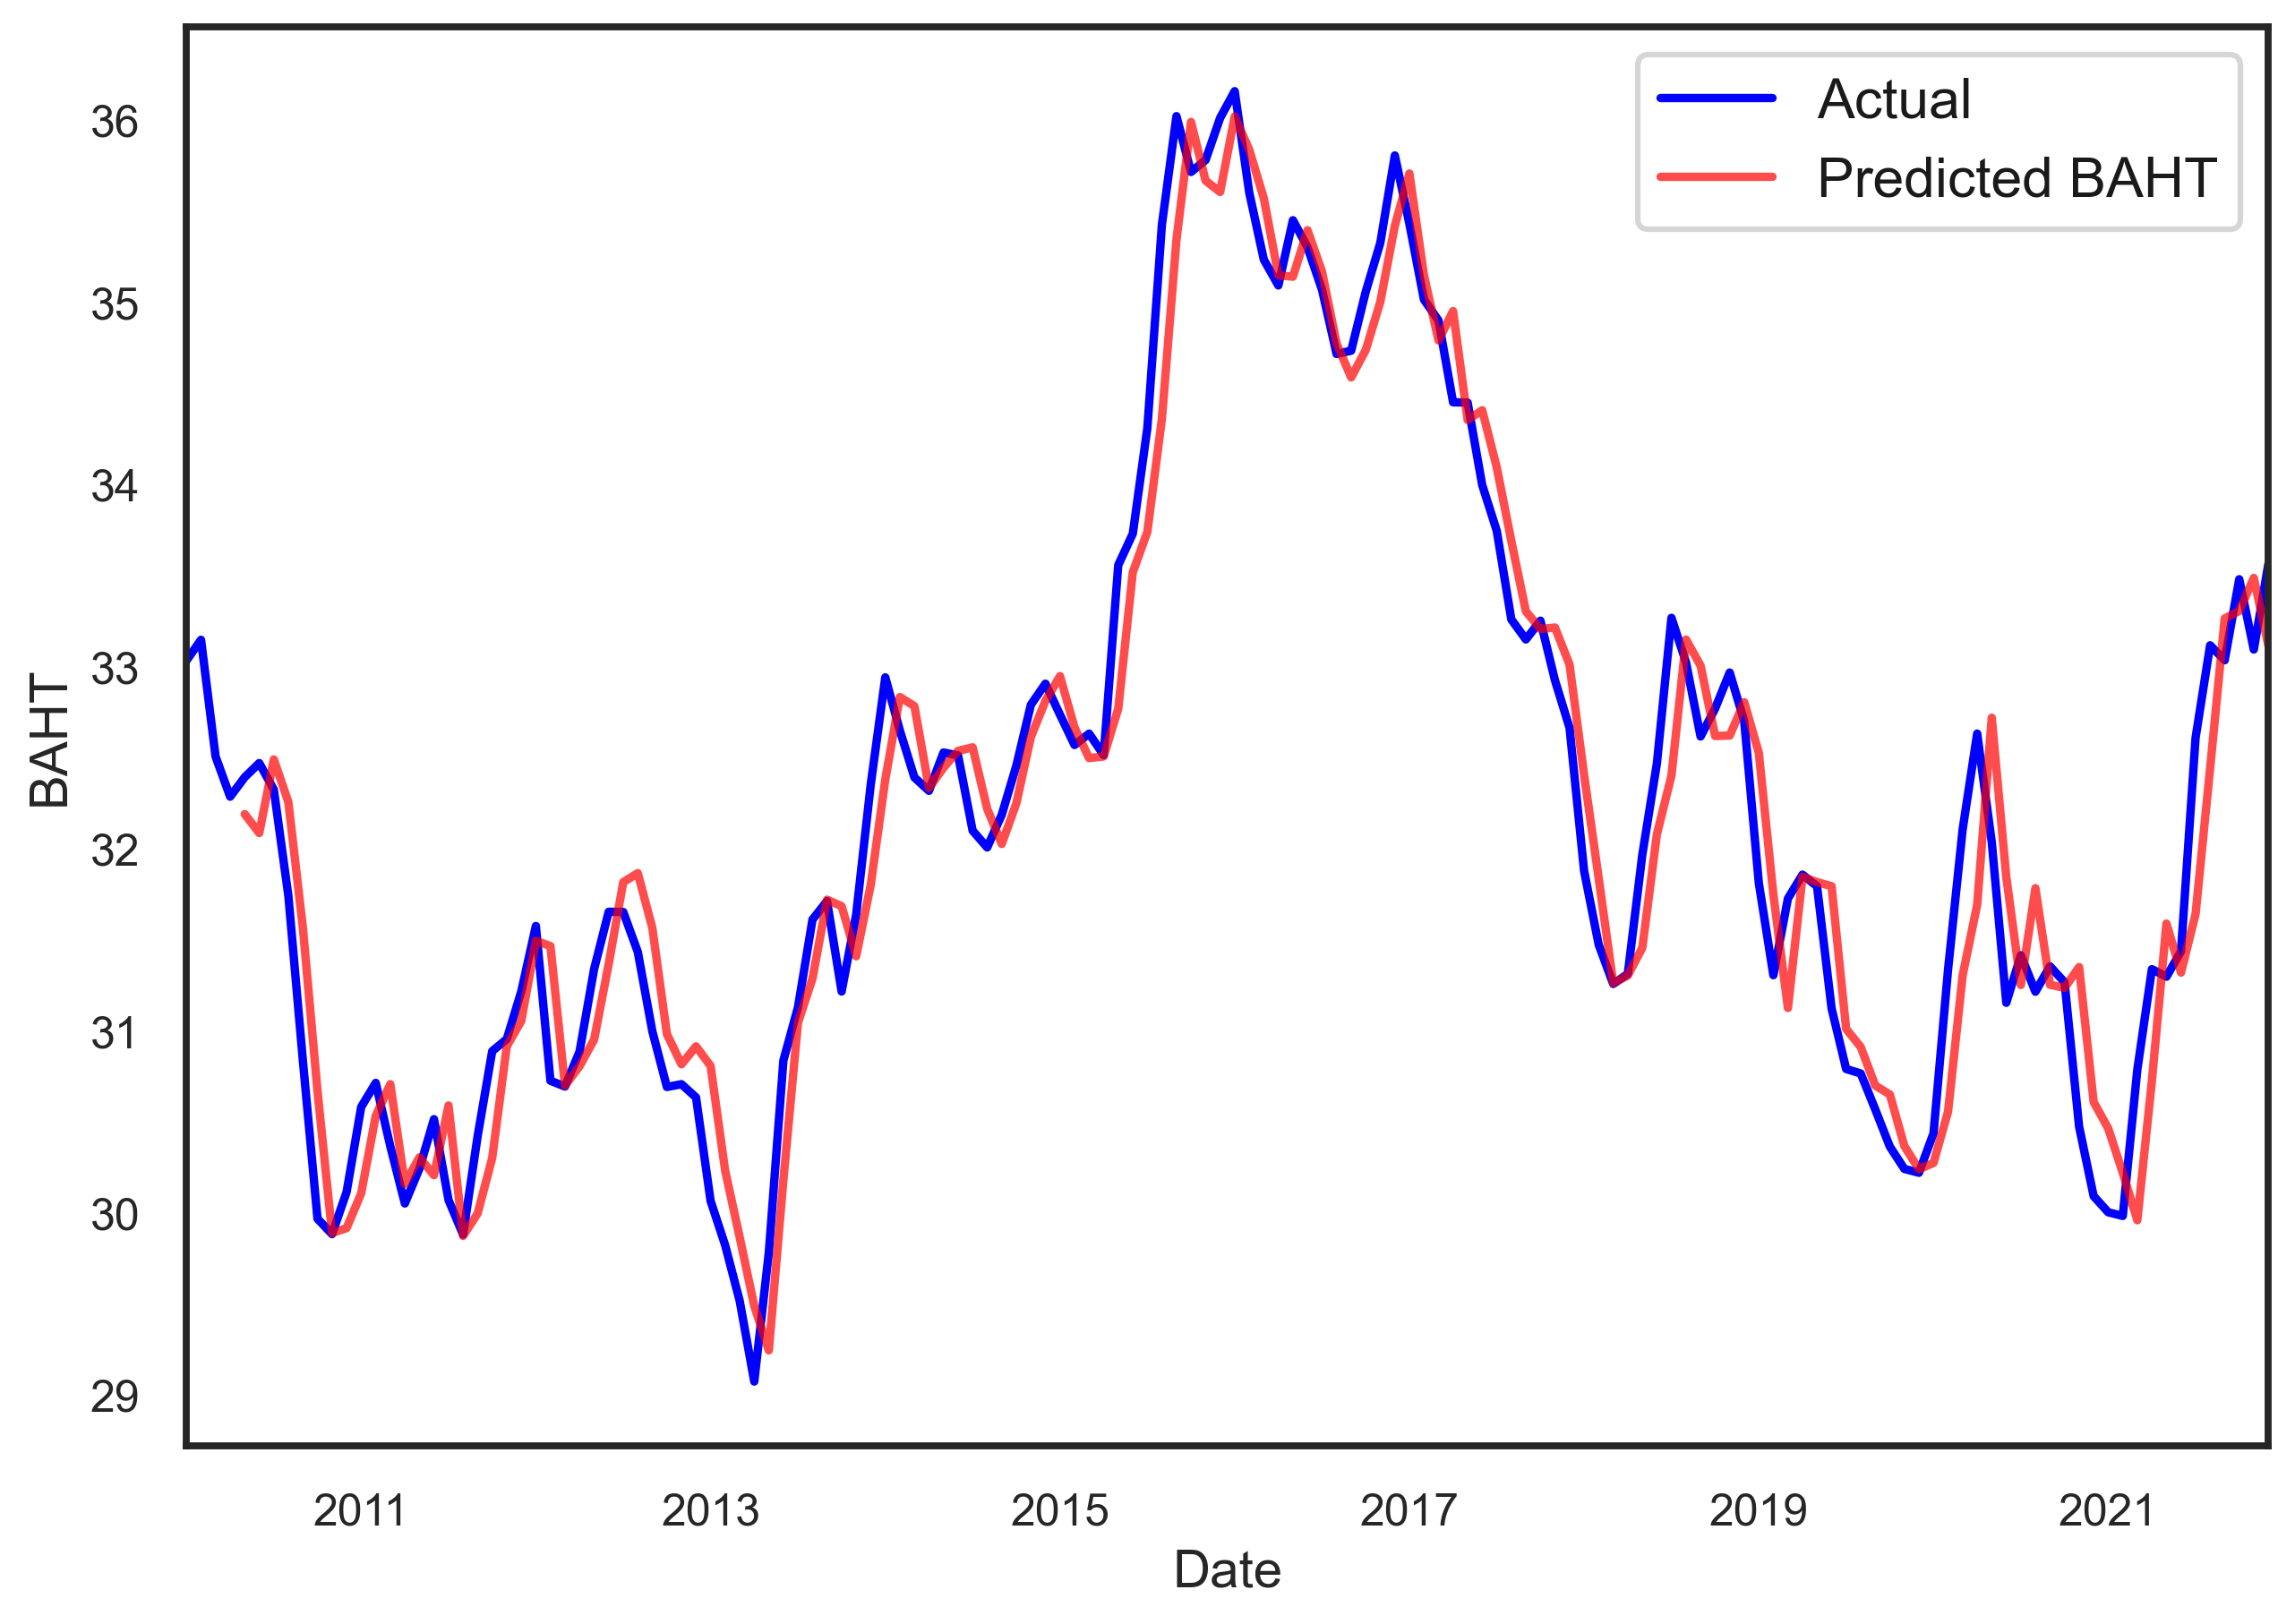

In [25]:
pred = ardl_model.get_prediction(dynamic=False)
ax = df.BAHT.plot(label="Actual", color="blue")
pred.predicted_mean.plot(ax=ax, label="Predicted BAHT", color="red", alpha=.7)
ax.set_xlabel("Date")
ax.set_ylabel("BAHT")
plt.legend(fontsize=15)
plt.show()


### Evaluated Model

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt

reg_df = pd.DataFrame({'actual': df['BAHT'], 'prediction': pred.predicted_mean})
reg_df.dropna(inplace=True)
reg_df.head()

# Calculate Error
print('RMSE: %.4f' % sqrt(mean_squared_error(reg_df['actual'], reg_df['prediction'])))
print('MSE: %.4f' % mean_squared_error(
    reg_df['actual'], reg_df['prediction']))
print('MAE: %.4f' % mean_absolute_error(
    reg_df['actual'], reg_df['prediction']))
print('MAPE: %.4f' % mean_absolute_percentage_error(
    reg_df['actual'], reg_df['prediction']))
print('R2: %.4f' % r2_score(reg_df['actual'], reg_df['prediction']))


RMSE: 0.4112
MSE: 0.1691
MAE: 0.3287
MAPE: 0.0103
R2: 0.9420


<AxesSubplot:xlabel='actual', ylabel='prediction'>

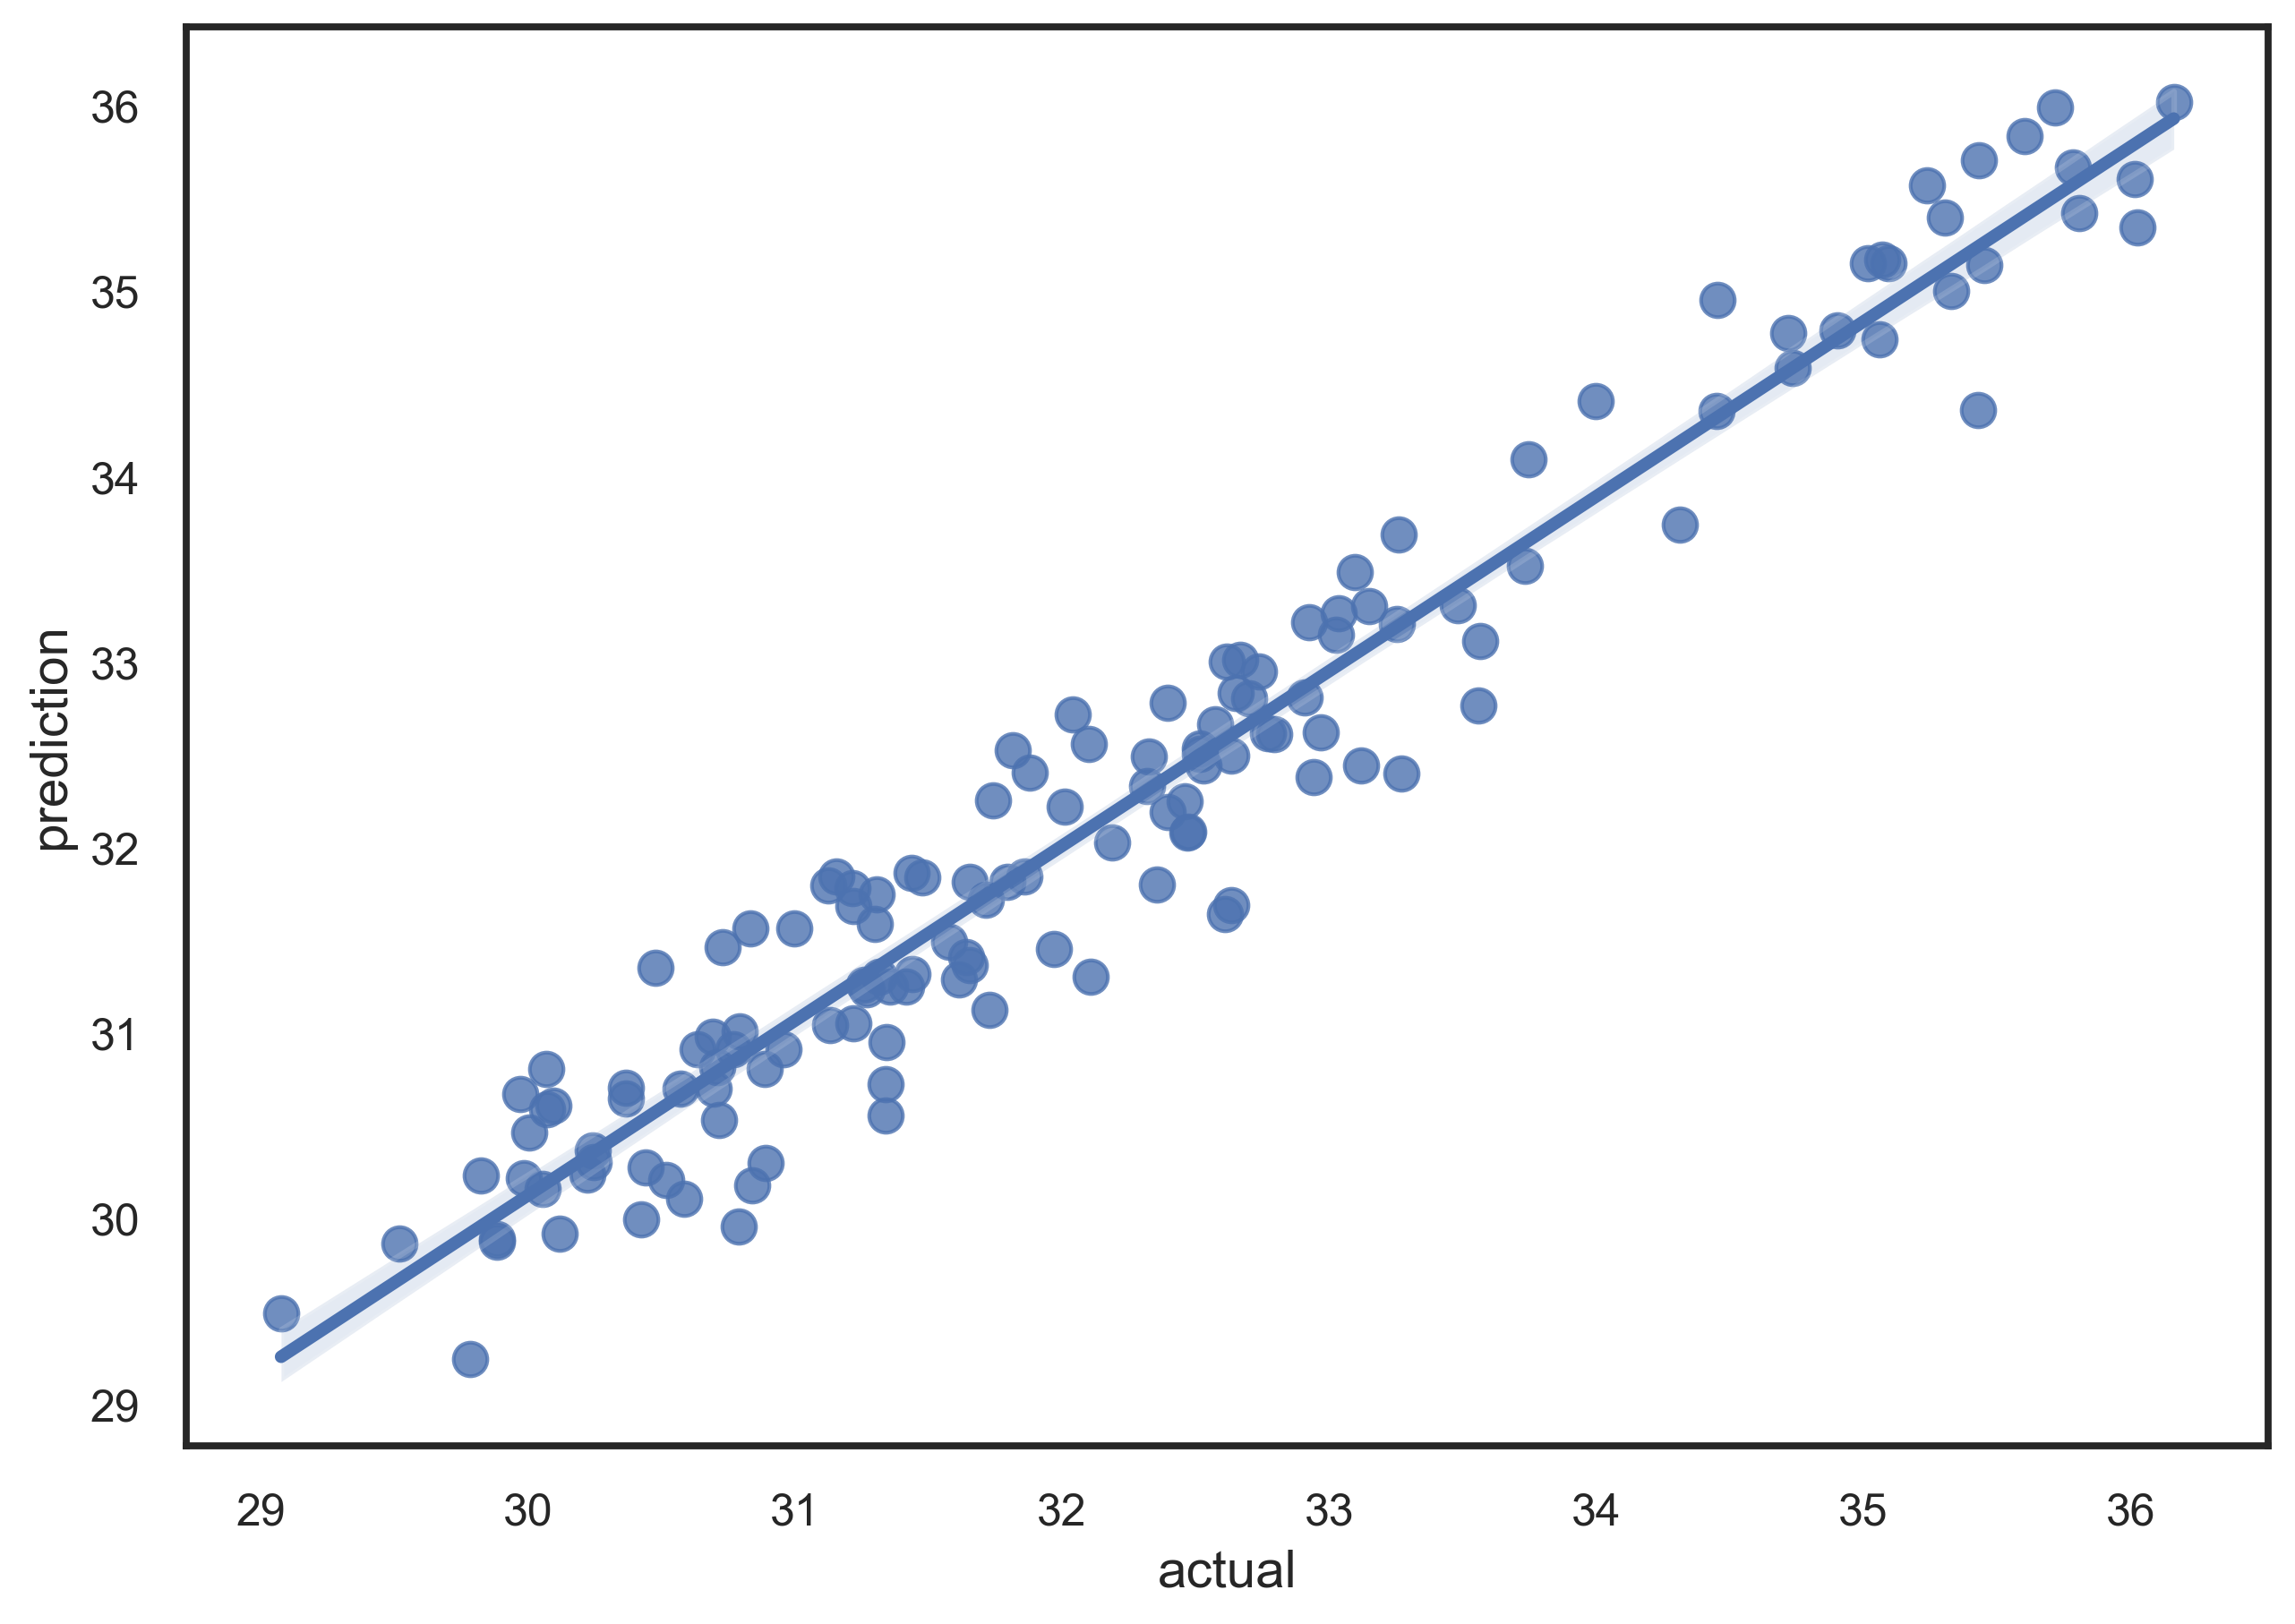

In [21]:
sns.regplot(x='actual', y='prediction', data=reg_df)


## 5. Unconstrained Error Correction Models (UECM)

In [22]:
ecm = UECM.from_ardl(ardl_model.model)
ecm_res = ecm.fit()
ecm_res.summary()


/Users/chatree/opt/miniconda3/envs/py4ai/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              UECM Model Results                              
==============================================================================
Dep. Variable:                 D.BAHT   No. Observations:                  144
Model:               UECM(1, 2, 4, 1)   Log Likelihood                 -74.240
Method:               Conditional MLE   S.D. of innovations             32.244
Date:                Sat, 04 Jun 2022   AIC                            174.479
Time:                        16:38:04   BIC                            212.721
Sample:                    05-01-2010   HQIC                           190.019
                         - 12-01-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.6278      0.757      0.829      0.409      -0.871       2.126
BAHT.L1          -0.0220      0.023     -0.961      0.338      -0.067       0.023
RMS_TH.L1       -17.8394     26.628     -0.670      0.504     -70.528      34.849
RINT_TH.L1        0.0971      0.072      1.340      0.183      -0.046       0.240
RINT_IPI.L1       0.2726      0.392      0.695      0.488      -0.504       1.049
D.RMS_TH.L0       8.7176     12.635      0.690      0.491     -16.282      33.717
D.RMS_TH.L1      14.6407     12.865      1.138      0.257     -10.815      40.096
D.RINT_TH.L0      0.0539      0.085      0.633      0.528      -0.114       0.222
D.RINT_TH.L1     -0.2116      0.099     -2.148      0.034      -0.407      -0.017
D.RINT_TH.L2     -0.1912      0.095     -2.015      0.046      -0.379      -0.003
D.RINT_TH.L3     -0.1795      0.082     -2.177      0.031      -0.343      -0.016
D.RINT_IPI.L0    -0.7141      0.578     -1.236      0.219      -1.857       0.429
=================================================================================
"""

In [23]:
ecm_res.ci_summary()

,coef,std err,t,P>|t|,[0.025,0.975]
const,-28.5792,5.525,-5.173,0.000,-39.510,-17.648
BAHT.L1,1.0000,0,nan,nan,1.000,1.000
RMS_TH.L1,812.1500,1611.191,0.504,0.614,-2375.866,4000.166
RINT_TH.L1,-4.4192,6.317,-0.700,0.484,-16.918,8.080
RINT_IPI.L1,-12.4090,22.960,-0.540,0.589,-57.840,33.022
